In [1]:
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [2]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [3]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [4]:
suffix = "_TrueVertexForSignal"

In [5]:
cut_config = "./cut_configs/BDTskimmer_preselections.py"

In [6]:
sig_sample_json_dir = './sample_configs/'
jsons = [f for f in os.listdir(sig_sample_json_dir) if ".json" in f]

signal_list = [ samp.split('.')[0] for samp in jsons if f"skimmed_sig_v2_mA_3m1_2018_aEM." in samp ]
print(signal_list)

bkg_sample_json_dir = '../../../configs/sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]

bkg_list = [ samp.split('.')[0] for samp in jsons if "skimmed_bkg" in samp ]
print(bkg_list)

['skimmed_sig_v2_mA_3m1_2018_aEM']
['skimmed_bkg_2018_DY', 'skimmed_bkg_2018_Diboson', 'skimmed_bkg_2018_QCD_TuneCP5_PSWeights', 'skimmed_bkg_2018_TTJetsDiLept', 'skimmed_bkg_2018_Top', 'skimmed_bkg_2018_Triboson', 'skimmed_bkg_2018_WJets', 'skimmed_bkg_2018_ZJets']


In [7]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_sig_v2_mA_3m1_2018_aEM


Output()

Output()

Completed in 3.38 min



In [8]:
for samp in bkg_list:
    if 'TTJetsDiLept' in samp: # currently not available ntuples
        continue
    
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_DY


Output()

Output()

Completed in 0.87 min

Start analyzing: skimmed_bkg_2018_Diboson


Output()

Output()

Completed in 0.56 min

Start analyzing: skimmed_bkg_2018_QCD_TuneCP5_PSWeights


Output()

Output()

Completed in 2.36 min

Start analyzing: skimmed_bkg_2018_Top


Output()

Output()

Completed in 3.65 min

Start analyzing: skimmed_bkg_2018_Triboson


Output()

Output()

Completed in 0.25 min

Start analyzing: skimmed_bkg_2018_WJets


Output()

Output()

Completed in 2.65 min

Start analyzing: skimmed_bkg_2018_ZJets


Output()

Output()

Completed in 2.45 min



## BDT

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [168]:
# BDT variables

'''
# Combo 1
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
             'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy',\
             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
             'delta_dxy_over_maxdxy', 'met_leadPt_ratio'
            ]


# Combo 2
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
             'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy',\
             'sel_vtx_cos_collinear', 'sel_vtx_sign_prod_eta', 'sel_vtx_pt_over_m', \
             'delta_dxy_over_maxdxy', 'met_leadPt_ratio'
            ]

# Combo 3
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
             'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy',\
             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
             'delta_dxy_over_maxdxy',
            ]


# Combo 4
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif',\
 'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]


# Combo 5
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif',\
 'sel_vtx_cos_collinear', 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]

# Combo 6
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy',\
 'sel_vtx_cos_collinear', 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]


# Combo 7
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy',\
 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]



# Combo 8
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy_signif','sel_vtx_projectedLxy',\
 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]


# Combo 9
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','sel_vtx_projectedLxy',\
 'sel_vtx_pt_over_m', \
 'delta_dxy_over_maxdxy',
]

# Combo 10
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','sel_vtx_cos_collinear',\
 'sel_vtx_pt_over_m','delta_dxy_over_maxdxy'
]


# Combo 11
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_cos_collinear',\
 'delta_dxy_over_maxdxy',
]
'''
# Combo 12
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_cos_collinear',\
 'sel_vtx_pt_over_m',
]

'''
# Combo 13
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy_signif','sel_vtx_projectedLxy',\
 'sel_vtx_pt_over_m',
]

# Combo 14
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
 'sel_vtx_minDxy','vxy_signif','sel_vtx_projectedLxy',
]
'''

"\n# Combo 13\nvariables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR', 'sel_vtx_minDxy','vxy_signif','sel_vtx_projectedLxy', 'sel_vtx_pt_over_m',\n]\n\n# Combo 14\nvariables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR', 'sel_vtx_minDxy','vxy_signif','sel_vtx_projectedLxy',\n]\n"

In [169]:
h5_dir = "./h5/"
sig_suffix = "_TrueVertexForSignal"
bkg_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]
bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

# To add in the future?
# e1 pt / e2 pt (e1 and e2 need to be sorted out in pT for now)

sig_data = []

sig_data_train = []
sig_data_test = []
sig_point_train = {'m1':[], 'delta':[], 'ctau':[]}
sig_point_test = {'m1':[], 'delta':[], 'ctau':[]}

sig_xsec_norm = []

sig_xsec_norm_train = []
sig_xsec_norm_test = []
sig_point_test = {'m1':[], 'delta':[], 'ctau':[]}

sig_point = {'m1':[], 'delta':[], 'ctau':[]}

m1s = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

        # for loop for each signal point to get the sig_data_test and sig_data_train
        for m1 in m1s:
            for delta in deltas:
                for ctau in ctaus:
                    mask_sig_point = (fin['m1'][()][mask] == m1) & (fin['delta'][()][mask] == delta) & (fin['ctau'][()][mask] == ctau)
                    idx_train = int(0.8*len(fin['m1'][()][mask][mask_sig_point]))
                    #print(fin['m1'][()][mask][mask_sig_point][:idx_train])
                    sig_data_train.append(np.concatenate([fin[v][()][mask][mask_sig_point][:idx_train].reshape(-1,1) for v in variables],axis=1))
                    sig_data_test.append(np.concatenate([fin[v][()][mask][mask_sig_point][idx_train:].reshape(-1,1) for v in variables],axis=1))

                    sig_point_train['m1'].append(fin['m1'][()][mask][mask_sig_point][:idx_train])
                    sig_point_train['delta'].append(fin['delta'][()][mask][mask_sig_point][:idx_train])
                    sig_point_train['ctau'].append(fin['ctau'][()][mask][mask_sig_point][:idx_train])

                    sig_point_test['m1'].append(fin['m1'][()][mask][mask_sig_point][idx_train:])
                    sig_point_test['delta'].append(fin['delta'][()][mask][mask_sig_point][idx_train:])
                    sig_point_test['ctau'].append(fin['ctau'][()][mask][mask_sig_point][idx_train:])

                    sig_xsec_norm_train.append(fin['wgt_norm'][()][mask][mask_sig_point][:idx_train])
                    sig_xsec_norm_test.append(fin['wgt_norm'][()][mask][mask_sig_point][idx_train:])
                    

sig_data_train = np.concatenate(sig_data_train, axis=0)
sig_data_test = np.concatenate(sig_data_test, axis=0)

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)

sig_xsec_norm_train = np.concatenate(sig_xsec_norm_train, axis=0)
sig_xsec_norm_test = np.concatenate(sig_xsec_norm_test, axis=0)

sig_point_train['m1'] = np.concatenate(sig_point_train['m1'], axis=0)
sig_point_train['delta'] = np.concatenate(sig_point_train['delta'], axis=0)
sig_point_train['ctau'] = np.concatenate(sig_point_train['ctau'], axis=0)

sig_point_test['m1'] = np.concatenate(sig_point_test['m1'], axis=0)
sig_point_test['delta'] = np.concatenate(sig_point_test['delta'], axis=0)
sig_point_test['ctau'] = np.concatenate(sig_point_test['ctau'], axis=0)

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Signal events 54961 -> 54961 after gen matching (raw counts)

Diboson: 767
DY: 9
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480

Number of total background events (raw counts): 76447


In [170]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

for ctau in [1, 10, 100]:
    for delta in [0.1, 0.2]:
        for m1 in [5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.]:
            idx = ((sig_point_train['m1'] == m1) & (sig_point_train['delta'] == delta))&(sig_point_train['ctau'] == ctau)
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            sig_subprocess[point] = idx
            print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses (training set) with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1: 154
m1_10.0_delta_0.1_ctau_1: 312
m1_20.0_delta_0.1_ctau_1: 400
m1_30.0_delta_0.1_ctau_1: 477
m1_40.0_delta_0.1_ctau_1: 573
m1_50.0_delta_0.1_ctau_1: 912
m1_60.0_delta_0.1_ctau_1: 729
m1_70.0_delta_0.1_ctau_1: 912
m1_80.0_delta_0.1_ctau_1: 959
m1_90.0_delta_0.1_ctau_1: 3758
m1_100.0_delta_0.1_ctau_1: 4810
m1_5.0_delta_0.2_ctau_1: 176
m1_10.0_delta_0.2_ctau_1: 324
m1_20.0_delta_0.2_ctau_1: 444
m1_30.0_delta_0.2_ctau_1: 615
m1_40.0_delta_0.2_ctau_1: 601
m1_50.0_delta_0.2_ctau_1: 64
m1_60.0_delta_0.2_ctau_1: 0
m1_70.0_delta_0.2_ctau_1: 1061
m1_80.0_delta_0.2_ctau_1: 0
m1_90.0_delta_0.2_ctau_1: 3352
m1_100.0_delta_0.2_ctau_1: 1980
m1_5.0_delta_0.1_ctau_10: 89
m1_10.0_delta_0.1_ctau_10: 205
m1_20.0_delta_0.1_ctau_10: 191
m1_30.0_delta_0.1_ctau_10: 407
m1_40.0_delta_0.1_ctau_10: 422
m1_50.0_delta_0.1_ctau_10: 564
m1_60.0_delta_0.1_ctau_10: 504
m1_70.0_delta_0.1_ctau_10: 560
m1_80.0_delta_0.1_ctau_10: 518
m1_90.0_delta_0.1_ctau_10:

## Reweight Backgrounds

### Background raw counts

In [171]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'{process}: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

Diboson: 767
DY: 9
QCD: 3
Top: 2006
Triboson: 92
WJets: 29090
ZJets: 44480


### Cutflow counts (xsec weighted)

In [172]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'{process}: {entries}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts}')

Diboson: 189.35027223825455
DY: 455.6547508239746
QCD: 632.250424861908
Top: 294.0013522002846
Triboson: 2.0868917726911604
WJets: 11204.390249389457
ZJets: 6256.761405692319
Total background counts (xsec weighted): 19034.49534697889


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [173]:
sf = {}
xsec_norm = {}

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf[process] = entries
        xsec_norm[process] = fin['wgt_norm'][()]

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [174]:
eff = {'QCD': 5.67763170e-05, \
       'Top': 1.29972802e-02, \
       'DY': 6.84993158e-04, \
       'Diboson': 5.27846365e-02, \
       'Triboson': 1.47270096e-01,\
       'WJets': 2.20440725e-01,\
       'ZJets': 5.65765493e-01,
      }

In [175]:
total_weighted = 0

for process in sf.keys():
    print(f'{process}: {sum(sf[process])*eff[process]}')
    total_weighted += sum(sf[process]*eff[process])

print(total_weighted)

Diboson: 40.14140205314688
DY: 1.2535486564496918
QCD: 0.1441701740280272
Top: 15.346907175320029
Triboson: 1.2343364841659745
WJets: 9919.713300155101
ZJets: 14216.90652980942
24194.74019448575


In [176]:
nBkg

76447

In [177]:
# SF
bkg_sf = []
bkg_xsec_norm = []

for process in sf.keys():
    bkg_sf += list(sf[process]*eff[process])
    bkg_xsec_norm += list(xsec_norm[process]*eff[process])

#print(len(bkg_sf))

In [178]:
xsec_norm['QCD']*eff['QCD']

array([0.00044529, 0.01772578, 0.01772578], dtype=float32)

In [179]:
set(bkg_xsec_norm)

{-0.008768425,
 -0.006692652,
 -0.0018502856,
 -0.00062421587,
 -0.0002116886,
 0.00016636733,
 0.0002116886,
 0.00044529405,
 0.00048210262,
 0.00056381087,
 0.00062421587,
 0.0006242159,
 0.0007078533,
 0.0018502856,
 0.0023449338,
 0.0031738435,
 0.0032812036,
 0.006692652,
 0.008768425,
 0.008782745,
 0.010455771,
 0.011419581,
 0.013761678,
 0.015364231,
 0.01624509,
 0.016502155,
 0.016980432,
 0.017725779,
 0.01888182,
 0.021940107,
 0.036256213,
 0.07595454,
 0.086272165,
 0.098302655,
 0.10451188,
 0.26204792,
 0.315949}

In [180]:
len(bkg_sf)

76447

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [181]:
#bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)
bkg_to_sig = total_weighted/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
#print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {total_weighted}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 54961
Background sample size (all subprocesses summed): 24194.74019448575
0.44021652070533196 more background than signal samples


In [182]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 62 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [183]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 62 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 1233.016129032258


In [184]:
#print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {total_weighted/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 390.2377450723508


In [185]:
#sig_sf = np.zeros(len(sig_xsec_norm)) # initialize
sig_sf = np.zeros(len(sig_data_train))

#nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
nSubprocessWeighted = total_weighted/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    print(f'{samp}: {sf}')

    sig_sf[samp_idx] = sf

print(sig_sf)

m1_5.0_delta_0.1_ctau_1: 2.5340113316386415
m1_10.0_delta_0.1_ctau_1: 1.2507620034370217
m1_20.0_delta_0.1_ctau_1: 0.975594362680877
m1_30.0_delta_0.1_ctau_1: 0.8181084802355362
m1_40.0_delta_0.1_ctau_1: 0.6810431851175406
m1_50.0_delta_0.1_ctau_1: 0.42789226433371796
m1_60.0_delta_0.1_ctau_1: 0.5353055487960916
m1_70.0_delta_0.1_ctau_1: 0.42789226433371796
m1_80.0_delta_0.1_ctau_1: 0.40692152770839496
m1_90.0_delta_0.1_ctau_1: 0.10384186936464895
m1_100.0_delta_0.1_ctau_1: 0.08113050833105005
m1_5.0_delta_0.2_ctau_1: 2.2172599151838113
m1_10.0_delta_0.2_ctau_1: 1.204437484791206
m1_20.0_delta_0.2_ctau_1: 0.8789138402530423
m1_30.0_delta_0.2_ctau_1: 0.6345329188168305
m1_40.0_delta_0.2_ctau_1: 0.6493140517010828
m1_50.0_delta_0.2_ctau_1: 6.097464766755481
m1_70.0_delta_0.2_ctau_1: 0.36780183324443994
m1_90.0_delta_0.2_ctau_1: 0.11641937502158436
m1_100.0_delta_0.2_ctau_1: 0.197089770238561
m1_5.0_delta_0.1_ctau_10: 4.384693764857874
m1_10.0_delta_0.1_ctau_10: 1.9035987564504917
m1_20.0

In [186]:
len(sig_sf)

42474

In [187]:
len(sig_data_train)

42474

### Train

In [188]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [189]:
from sklearn.utils import shuffle

In [190]:
rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
'''
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)
'''

sig_train = shuffle(sig_data_train, random_state=random_state)
sig_test = shuffle(sig_data_test, random_state=random_state)
sig_train_sf = shuffle(sig_sf_arr, random_state=random_state)

sig_train_xsec_norm = shuffle(sig_xsec_norm_train, random_state=random_state)
sig_test_xsec_norm = shuffle(sig_xsec_norm_test, random_state=random_state)

sig_train_m1 = shuffle(sig_point_train['m1'], random_state=random_state)
sig_test_m1 = shuffle(sig_point_test['m1'], random_state=random_state)

sig_train_delta = shuffle(sig_point_train['delta'], random_state=random_state)
sig_test_delta = shuffle(sig_point_test['delta'], random_state=random_state)

sig_train_ctau = shuffle(sig_point_train['ctau'], random_state=random_state)
sig_test_ctau = shuffle(sig_point_test['ctau'], random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
#test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [145]:
#test_ctau[np.where(y_test == ct)] # signal

In [146]:
test_ctau[np.where(y_test == 1)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([100.,   1.,   1., ...,   1.,   1.,   1.])

In [147]:
test_delta[np.where(y_test == 1)]

array([0.2, 0.2, 0.1, ..., 0.2, 0.1, 0.1])

In [60]:
bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

# fit model
bst.fit(train, y_train, sample_weight=train_sf)
#bst.fit(train, y_train)


KeyboardInterrupt



In [751]:
# make predictions
preds = bst.predict(test)

In [752]:
os.system('mkdir -p plots')

0

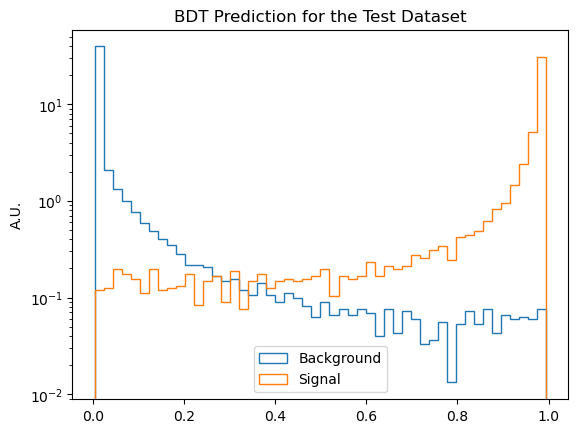

In [753]:
bins = 50

h,bins,_ = plt.hist(preds[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
#plt.savefig(f'plots/BDT_inclusive_score.png')
plt.yscale('log')

[Text(0, 0, 'sel_vtx_chi2'),
 Text(0, 1, 'sel_vtx_METdPhi'),
 Text(0, 2, 'vxy_signif'),
 Text(0, 3, 'sel_vtx_m'),
 Text(0, 4, 'sel_vtx_minDxy'),
 Text(0, 5, 'sel_vtx_dR'),
 Text(0, 6, 'sel_vtx_projectedLxy')]

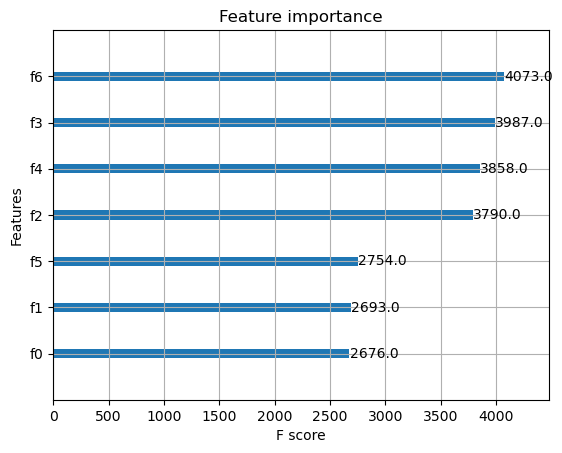

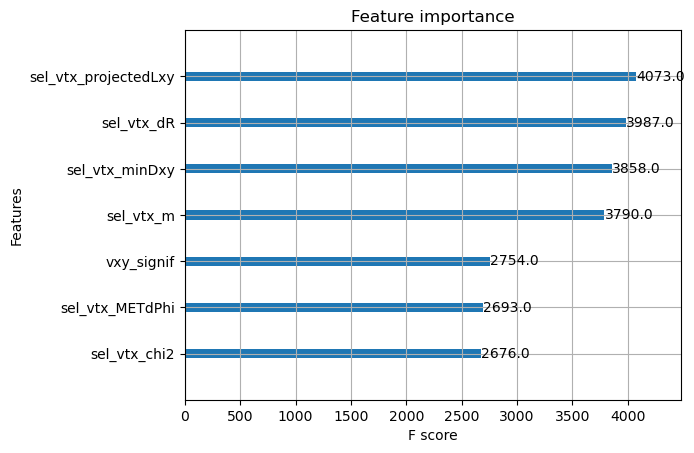

In [754]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)
#plt.savefig(f'plots/BDT_inclusive_importance_bst.png', bbox_inches = "tight")

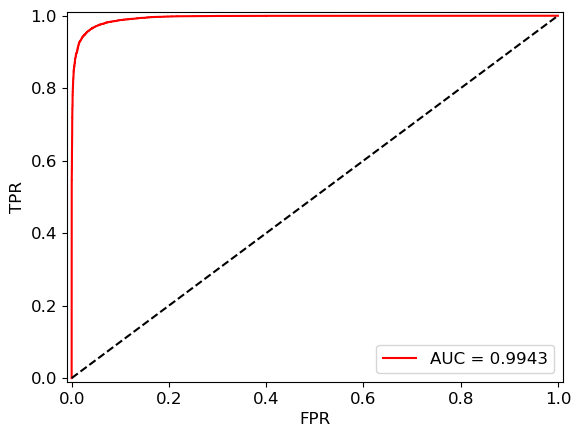

In [755]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = roc_auc_score(y_test, preds)
precision, recall, thresholds2 = precision_recall_curve(y_test, preds)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig(f'plots/BDT_inclusive_roc_curve.png')

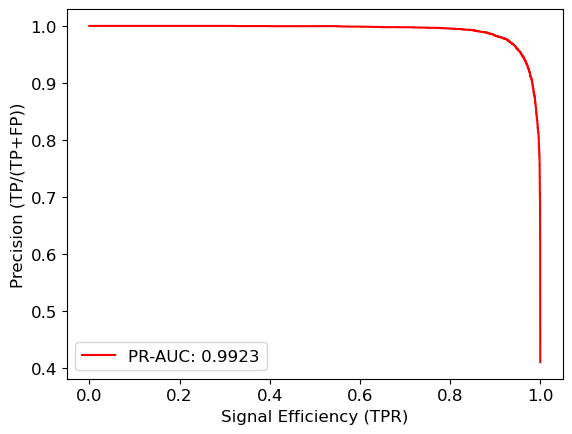

In [756]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, preds)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

### Save and load

In [148]:
os.system(f'mkdir -p models')

0

In [758]:
bst.save_model(f'models/BDT_comb14.json')

In [191]:
trained_model = xgb.XGBRegressor()
trained_model.load_model(f'models/BDT_comb12.json')

In [192]:
prediction = trained_model.predict(test)

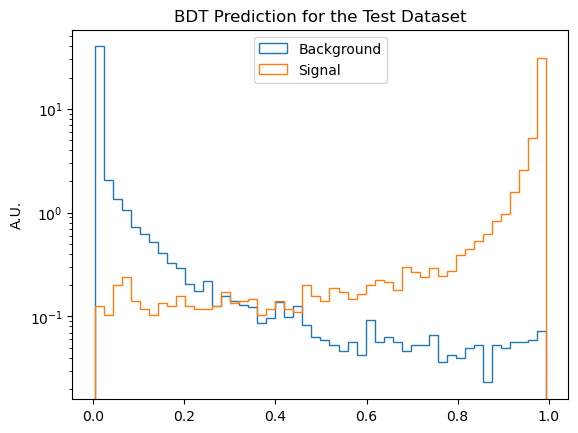

In [195]:
bins = 50

h_bkg,bins,_ = plt.hist(prediction[y_test==0],bins=bins,density=True,histtype='step', label='Background')
h_sig,bins,_ = plt.hist(prediction[y_test==1],bins=bins,density=True,histtype='step', label='Signal')

plt.legend()
plt.title('BDT Prediction for the Test Dataset')

plt.ylabel('A.U.')
plt.yscale('log')

In [152]:
h_sig = h_sig[::-1]
h_sig

array([30.75134988,  5.42133407,  2.55908758,  1.35356698,  1.00107859,
        0.86007902,  0.58513573,  0.4441405 ,  0.51463745,  0.39479037,
        0.38774171,  0.24674398,  0.21854467,  0.28199312,  0.21149548,
        0.2255945 ,  0.19739518,  0.18329608,  0.16919587,  0.21149484,
        0.14804683,  0.16919587,  0.15509622,  0.15509668,  0.1762457 ,
        0.16214629,  0.14099656,  0.14804661,  0.11984726,  0.16214604,
        0.1268971 ,  0.09869774,  0.14804639,  0.14099677,  0.14804639,
        0.1268971 ,  0.11279742,  0.15509633,  0.09869767,  0.09164783,
        0.16919613,  0.1057475 ,  0.16214617,  0.16214623,  0.15509639,
        0.1057475 ,  0.19739541,  0.19034554,  0.09164785,  0.13394686])

In [153]:
h_bkg = h_bkg[::-1]
h_bkg

array([7.26284442e-02, 6.93273599e-02, 3.63142221e-02, 6.93271513e-02,
       2.97117257e-02, 6.93271513e-02, 4.29168079e-02, 1.65065143e-02,
       4.95193938e-02, 5.94232725e-02, 5.94234513e-02, 5.61219796e-02,
       5.28206867e-02, 6.93271513e-02, 2.97117257e-02, 4.62181008e-02,
       7.59297371e-02, 7.26286627e-02, 4.95193938e-02, 5.28206867e-02,
       6.60260570e-02, 7.59297371e-02, 7.59297371e-02, 6.27247542e-02,
       5.28206867e-02, 7.59298513e-02, 1.05641373e-01, 7.92311492e-02,
       1.15545426e-01, 1.18846545e-01, 1.12244128e-01, 1.02340234e-01,
       1.18846545e-01, 1.35353213e-01, 1.28750424e-01, 1.48558405e-01,
       1.61763596e-01, 1.78269952e-01, 2.31090678e-01, 2.50898450e-01,
       2.34392150e-01, 3.40033426e-01, 3.99456743e-01, 5.28207463e-01,
       5.77726912e-01, 8.12118669e-01, 1.05971622e+00, 1.33042230e+00,
       2.10292557e+00, 3.96155523e+01])

In [154]:
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.array(h_bkg_sum)

/tmp/ipykernel_7242/326739833.py:17: RuntimeWarning: invalid value encountered in divide
  np.array(h_sig_sum)/np.array(h_bkg_sum)


array([         nan, 423.40642458, 254.81651975, 217.26463141,
       161.8973969 , 148.16119007, 121.01019381, 109.18064263,
       105.83617774,  95.46188854,  85.21364289,  77.07342784,
        70.60481202,  65.46724462,  59.81201549,  57.81098196,
        54.858719  ,  50.47201673,  46.90828601,  44.81062567,
        42.8139735 ,  40.47554063,  38.09801281,  35.98790291,
        34.44229356,  33.27946787,  31.69119232,  29.67999596,
        28.36347652,  26.5988655 ,  25.02716574,  23.69957491,
        22.60347758,  21.4711071 ,  20.30776489,  19.32336803,
        18.28964475,  17.27906387,  16.30211916,  15.16470716,
        14.09656243,  13.25171805,  12.16541438,  11.10985132,
         9.96365726,   8.95554088,   7.83007143,   6.73955585,
         5.73752677,   4.63508198])

In [155]:
prediction.shape

(25937,)

In [156]:
test_xsec_norm.shape

(25937,)

In [157]:
y_test.shape

(25937,)

In [158]:
test_xsec_norm[ (y_test == 1) & (prediction > 0.9) ].shape

(9287,)

In [159]:
# S/B scan on the score (xsec weighted)
def yieldScan(test_xsec_norm, thresholds):
    sig_yields = []
    bkg_yields = []
    
    for t in thresholds:
        sig_yields.append(np.sum(test_xsec_norm[ (y_test == 1) & (prediction > t) ]))
        bkg_yields.append(np.sum(test_xsec_norm[ (y_test == 0) & (prediction > t) ]))
        
    return sig_yields, bkg_yields

# threshold scan

thresholds = np.arange(0,1,step=0.0001)
sig_yields, bkg_yields = yieldScan(test_xsec_norm,thresholds)



In [160]:
np.where(thresholds == 0.9995)[0][0]

9995

In [161]:
bkg_yields[np.where(thresholds == 0.99)[0][0]]

IndexError: index 0 is out of bounds for axis 0 with size 0

[Text(0, 0, 'sel_vtx_chi2'),
 Text(0, 1, 'sel_vtx_pt_over_m'),
 Text(0, 2, 'vxy_signif'),
 Text(0, 3, 'sel_vtx_METdPhi'),
 Text(0, 4, 'sel_vtx_dR'),
 Text(0, 5, 'sel_vtx_m'),
 Text(0, 6, 'sel_vtx_minDxy'),
 Text(0, 7, 'sel_vtx_projectedLxy')]

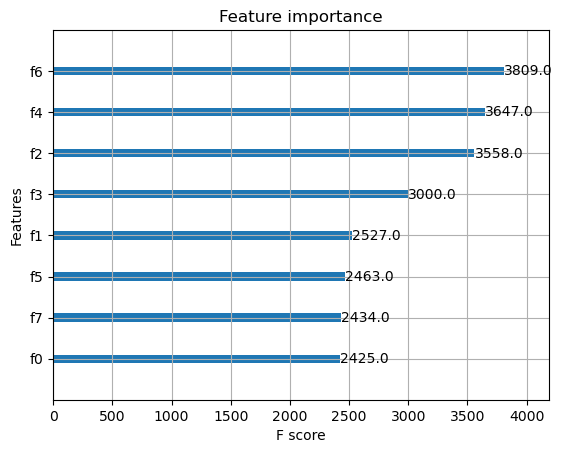

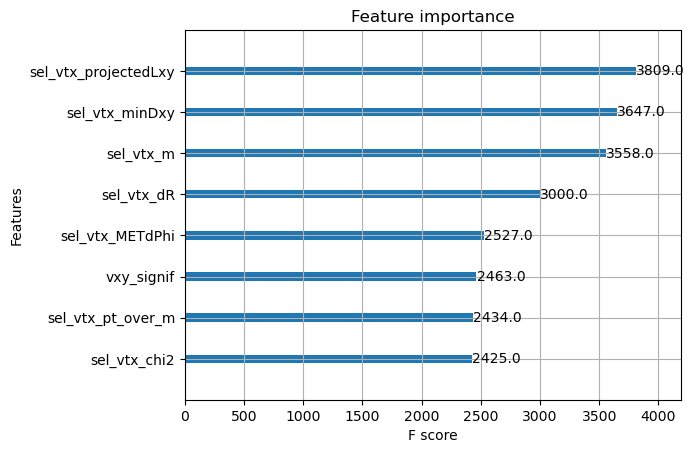

In [162]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

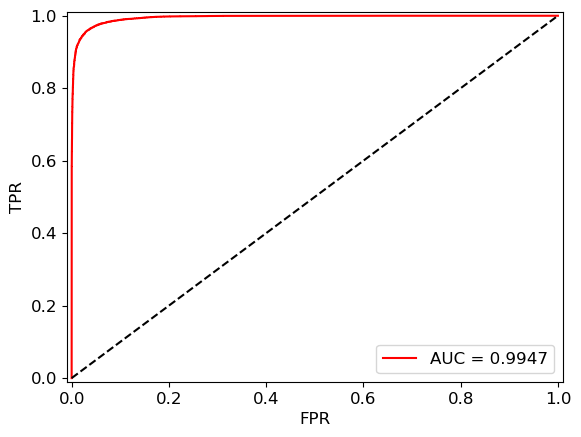

In [163]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# make predictions

fpr, tpr, thresholds = roc_curve(y_test, prediction)
auc = roc_auc_score(y_test, prediction)
precision, recall, thresholds2 = precision_recall_curve(y_test, prediction)

plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)
#plt.savefig('plots/roc_curve_weighted_training.png')

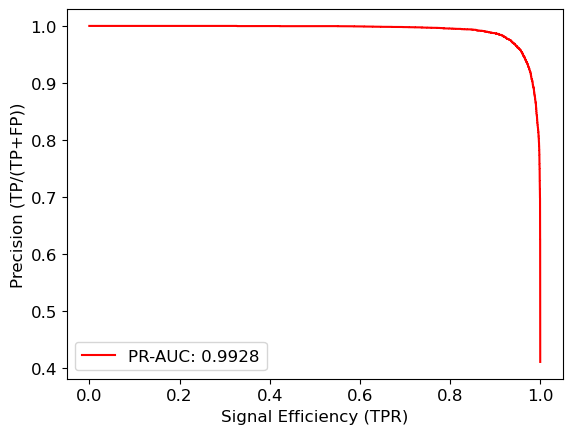

In [164]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, _ = precision_recall_curve(y_test, prediction)

#idx = np.where(recall > 0.005)
#recall[idx]

plt.plot(recall, precision, color = "red", label=f"PR-AUC: {auc(recall, precision):.4f}")

#plt.xlim([-0.01, 1.01])
#plt.ylim([-0.01, 1.01])

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
#plt.savefig(f'plots/BDT_inclusive_PR_curve.png')

### WP

In [165]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [166]:
tpr_WP = {'tight': 0.7, 'medium': 0.85, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [167]:
epsilon = 0.005

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9792826175689697
medium threshold: 0.9282112717628479
loose threshold: 0.8343673348426819
